## Важность инициализации веса при обучении нейронных сетей

Обучение нейронной сети полностью зависит от типа параметров, используемых для инициализации сети. Если инициализация параметров выполнена правильно, оптимизация или результат будут достигнуты за минимальное время, а неправильная инициализация приведет к проблемам. Простыми словами, производительность нейронной сети зависит от того, как инициализируются ее параметры при запуске обучения. Если мы обучаем нейронную сеть со случайными весами, то выходные данные становятся невоспроизводимыми. С другой стороны, если мы будем обучать нейронную сеть с постоянно заданными весами, то для сходимости потребуется много времени. В этой статье мы сравним точность всех инициализаторов keras, а также рассмотрим визуализацию. Модель была обучена в течение 20 эпох, и выбран набор данных MNIST.

Consider upvoting if it helps you!

**Data and Model**

Чтобы наглядно представить и понять уровень производительности инициализаторов, используется набор данных MNIST. 

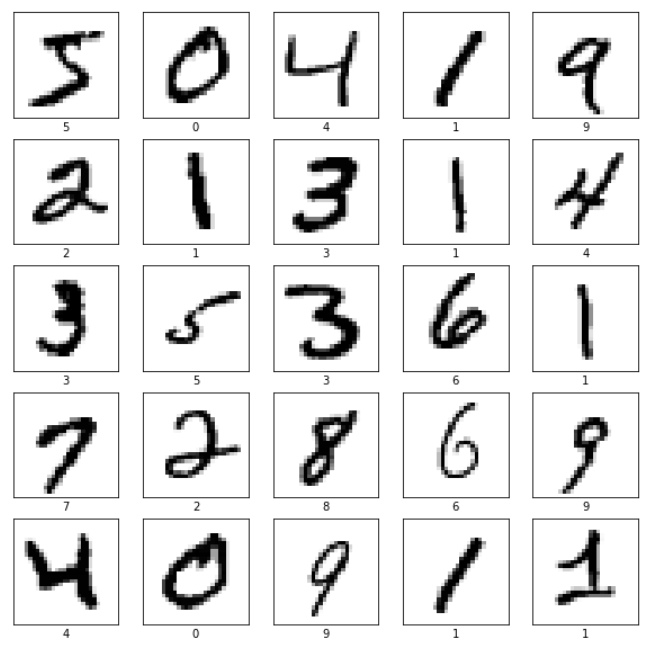

Архитектура модели, используемой для обучения, следующая:

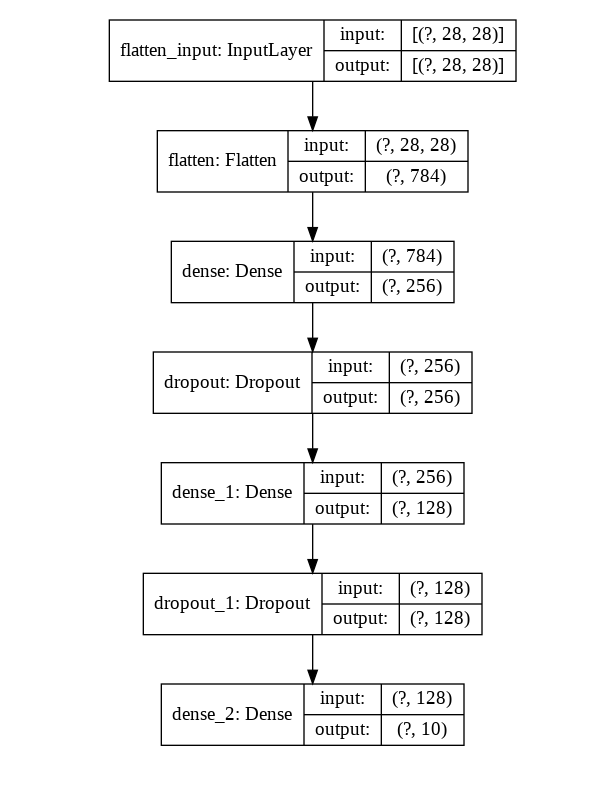

Конечный плотный слой имеет форму (10, ) и функцию активации `softmax`, поскольку это дало бы нам вероятность 10 различных классов, то есть от 0 до 9. Архитектура модели останется неизменной для всех инициализаторов, которые будут использоваться в экспериментальных целях. `Adam` и `sparse_categorical_cross entropy` будут использоваться в качестве оптимизатора и функции потерь соответственно. Модель обучалась в общей сложности 20 эпох.

In [ ]:
import tensorflow as tf
print(tf.__version__)

In [ ]:
# Gather data and preprocess it
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

In [ ]:
CLASS_NAMES = ['0', '1', '2', '3', '4',
               '5', '6', '7', '8', '9']

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(True)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.xlabel(CLASS_NAMES[y_train[i]])
plt.show()

In [ ]:
#!pip install wandb
import wandb

In [ ]:
from wandb.keras import WandbCallback

In [ ]:
def training(init_scheme):
    if isinstance(init_scheme, str):
        wandb.init(project='weight-initialization-tb', sync_tensorboard=True,
                   id=init_scheme)
    else:
        wandb.init(project='weight-initialization-tb', sync_tensorboard=True,
                   id=str(init_scheme))
    
    model = tf.keras.models.Sequential([
        tf.keras.layers.Flatten(input_shape=(28, 28)),
        tf.keras.layers.Dense(256, activation='relu', kernel_initializer=init_scheme,
            bias_initializer='zeros'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu', kernel_initializer=init_scheme,
            bias_initializer='zeros'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation='softmax', kernel_initializer=init_scheme,
            bias_initializer='zeros')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    
    return model, wandb.run.dir

### Zeros  

В этом методе всем весовым коэффициентам, связанным с входными данными, присваивается значение, равное нулю. Следовательно, производная, соответствующая функции потерь, одинакова для каждого веса на каждой итерации. Тогда это похоже на линейную модель.

In [ ]:
model_w_zeros, run_dir = training(init_scheme='zeros')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

model_w_zeros.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

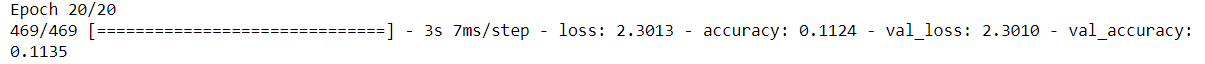

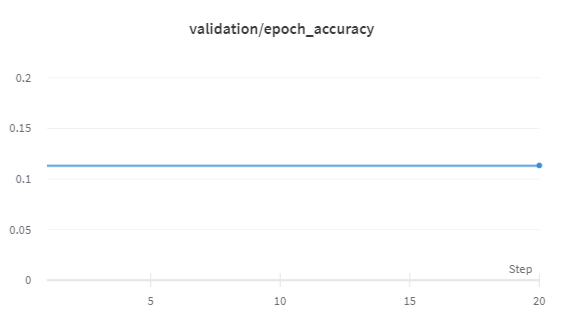

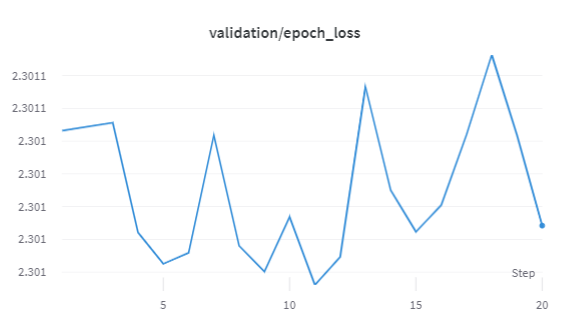

### Ones

В этом методе все веса, связанные с входными данными, присваиваются единице, но это все же сравнительно лучше, чем присваивать веса нулю, потому что произведение не равно нулю.

In [ ]:
model_w_ones, run_dir = training(init_scheme='ones')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

model_w_ones.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

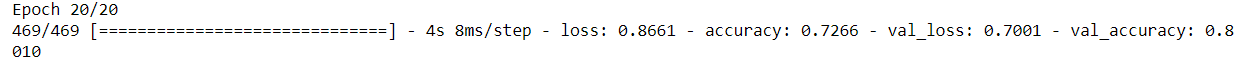

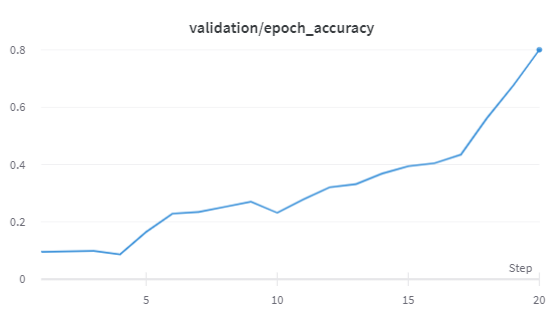

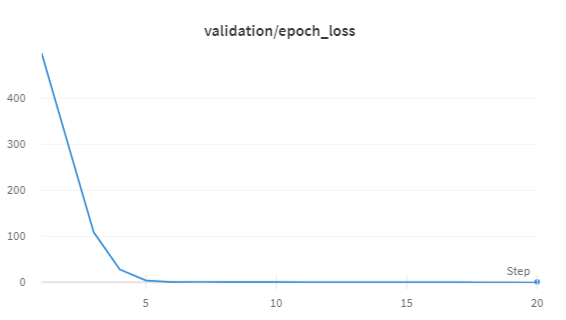

### Orthogonal

Ортогональная инициализация оказывается действительно полезной при оптимизации глубоких нейронных сетей. Она ускоряет сходимость по сравнению со стандартной гауссовой инициализацией. Для глубоких нейронных сетей ширина, необходимая для эффективной сходимости к глобальному минимуму при ортогональной инициализации, не зависит от глубины. Во время выполнения он генерирует случайную ортогональную матрицу. Ортогональный инициализатор возвращает тензор, который при умножении на его транспонирование дает идентичный тензор.
* gain: Коэффициент умножения, применяемый к ортогональной матрице.
* seed: Используется для запуска генератора случайных чисел.

In [ ]:
Orthogonal, run_dir = training(init_scheme='Orthogonal')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

Orthogonal.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

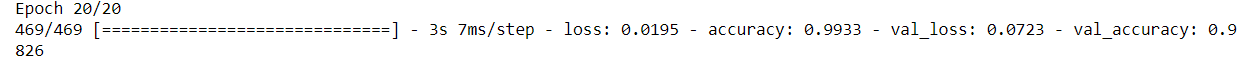

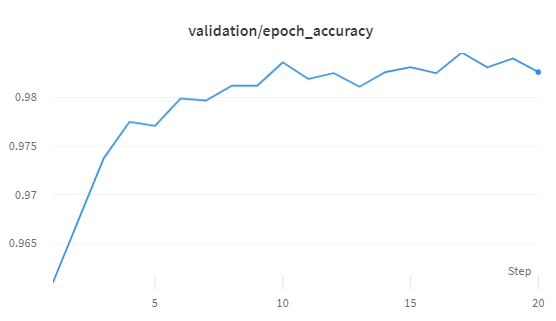

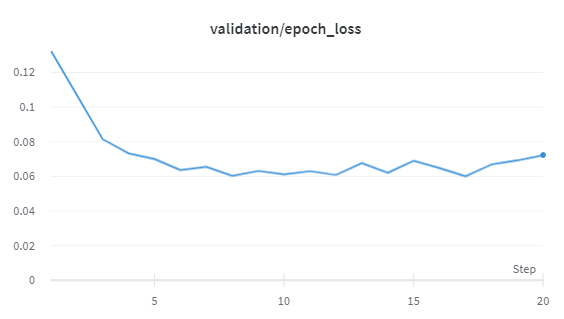

### Identity

Identity initializer returns a tensor with 0’s everywhere except for 1’s at the diagonal. It is only used for 2D matrices.<br>
Arguments:
* gain: Multiplicative factor to apply to the identity matrix.
* dtype: The type of the output.

In [ ]:
Identity, run_dir = training(init_scheme='Identity')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

Identity.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

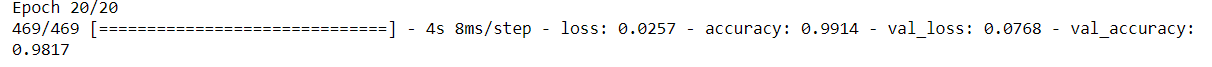

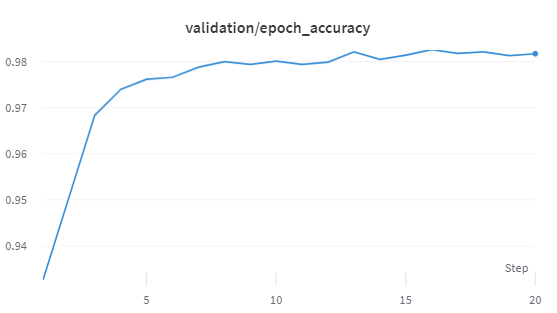

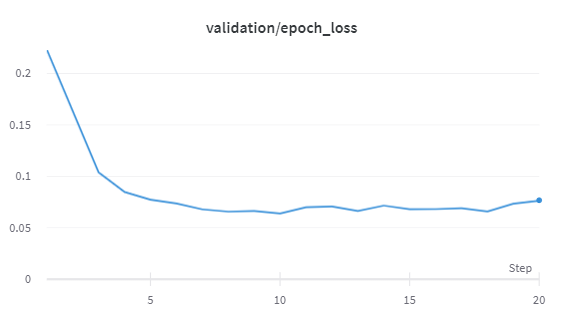

### Random Normal 

Присвоение случайных значений веса лучше, чем присвоение единиц или нулей в качестве значений веса, поскольку мы видели ранее, что точность инициализаторов единицы и нуля достаточно низкая. С другой стороны, если случайно инициализированные значения веса будут очень высокими или очень низкими, то это может привести к проблемам, известным как взрывающиеся градиенты и исчезающие градиенты соответственно.
В этом методе инициализатор генерирует тензоры с нормальным распределением.
Аргументы:
* mean: a python scalar or a scalar-tensor. Mean of the random values to generate.
* stddev: a python scalar or a scalar-tensor. The standard deviation of the random values to generate.
* seed: A Python integer. Used to seed the random generator.


In [ ]:
rand_normal, run_dir = training(init_scheme='RandomNormal')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

rand_normal.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

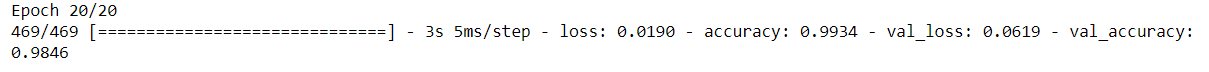

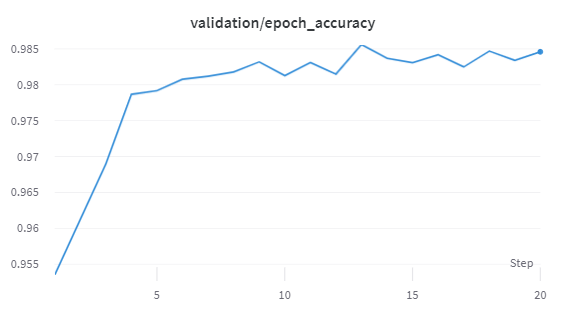

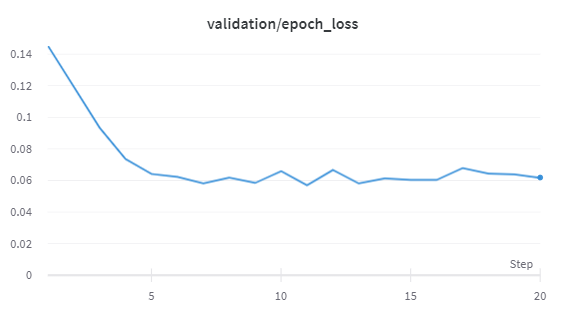

### Random Uniform 

В этом методе инициализатор генерирует тензоры с равномерным распределением.
Arguments:
Аргументы:
* minval: скаляр или скалярно-тензорный параметр. Нижняя граница диапазона генерируемых случайных значений.
* maxval: скаляр или скалярно-тензорный параметр. Верхняя граница диапазона генерируемых случайных значений. Значение по умолчанию равно 1 для типов с плавающей точкой.
* начальное значение: целое число Python. Используется для запуска генератора случайных чисел.


In [ ]:
rand_uniform, run_dir = training(init_scheme='RandomUniform')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

rand_uniform.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

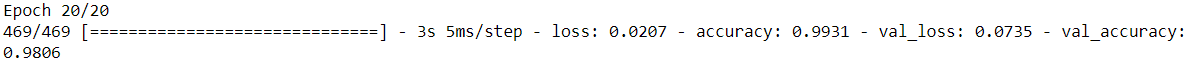

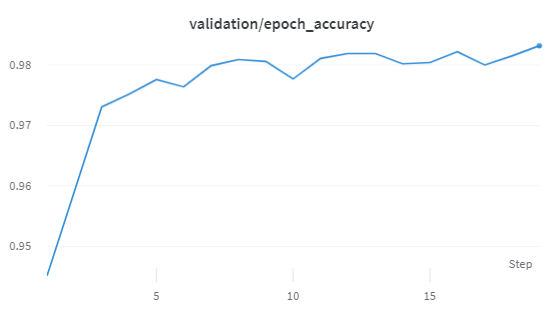

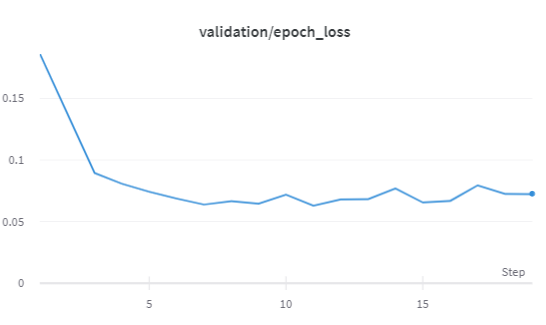

### Glorot Normal

Обычный инициализатор Glorot также известен как обычный инициализатор Xavier. Он похож на обычный инициализатор `He`, но используется для функций активации tanh. Он извлекает выборки из усеченного нормального распределения с центром в 0 с помощью stddev = sqrt(2 / (fan_in + fan_out)) где fan_in - количество входных единиц в весовом тензоре, а fan_out - количество выходных единиц в весовом тензоре.
Аргументы:
* начальное значение: целое число на языке Python. Используется для запуска генератора случайных чисел.

In [ ]:
glorot_normal, run_dir = training(init_scheme='glorot_normal')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

glorot_normal.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

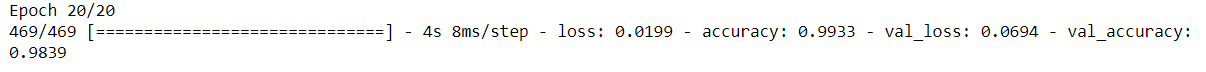

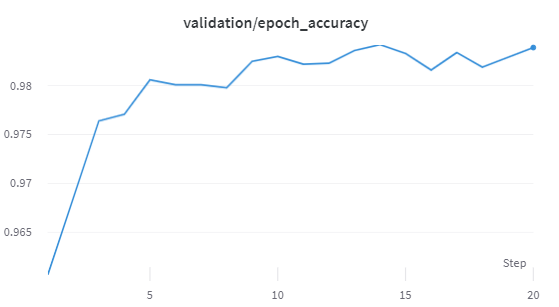

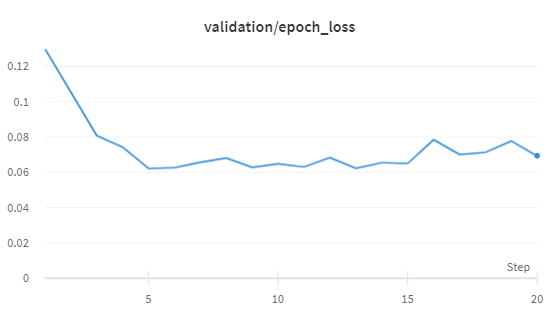

### Glorot Uniform 

Извлекает выборки из равномерного распределения в пределах [-предел, предел], где предел равен sqrt(6 / (fan_in + fan_out)) где fan_in - количество входных единиц в весовом тензоре, а fan_out - количество выходных единиц в весовом тензоре.<br>
Аргументы:
* начальное значение: целое число на языке Python. Используется для запуска генератора случайных чисел.

In [ ]:
glorot_uniform, run_dir = training(init_scheme='glorot_uniform')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

glorot_uniform.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

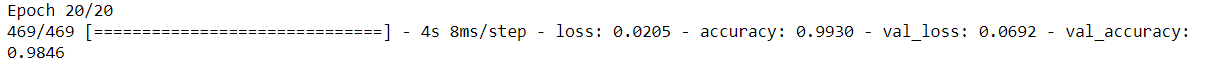

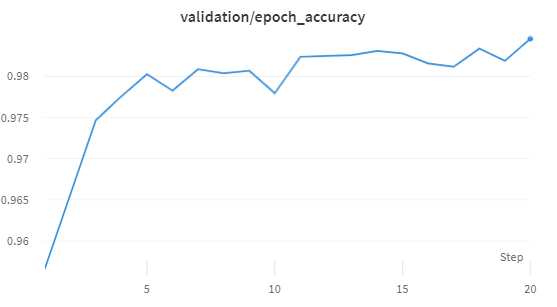

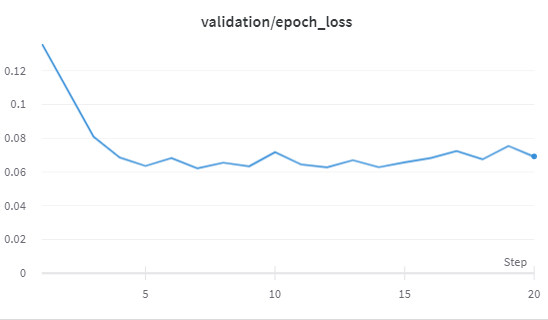

### He Normal 

Он извлекает выборки из усеченного нормального распределения с центром в 0 с помощью stddev = sqrt(2 / fan_in), где fan_in - это количество входных единиц в весовом тензоре.<br>
Аргументы:
* начальное значение: целое число в Python. Используется для запуска генератора случайных чисел.

In [ ]:
he_normal, run_dir = training(init_scheme='he_normal')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

he_normal.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

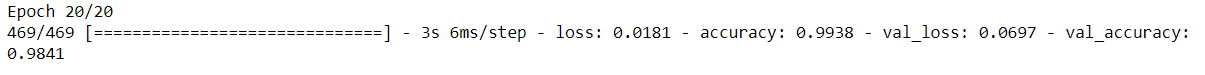

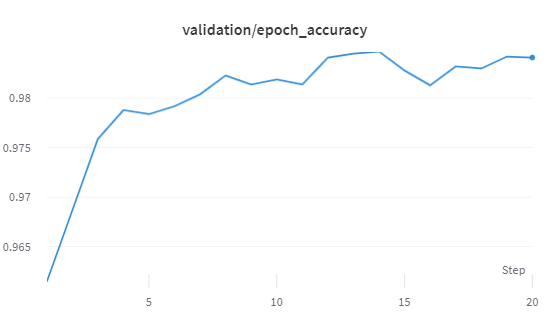

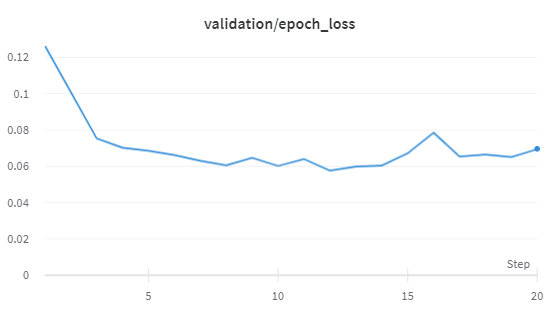

### He Uniform

В этом методе выборки берутся из равномерного распределения в пределах [-предел, предел], где предел равен sqrt(6 / fan_in), где fan_in - количество входных единиц в тензоре веса.<br>
Аргументы:
* начальное значение: целое число в Python. Используется для запуска генератора случайных чисел.

In [ ]:
he_uniform, run_dir = training(init_scheme='he_uniform')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

he_uniform.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

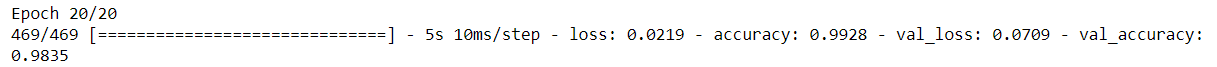

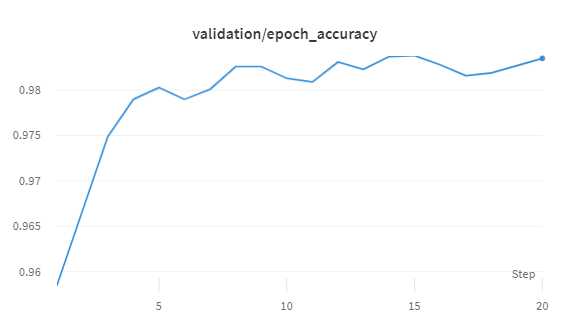

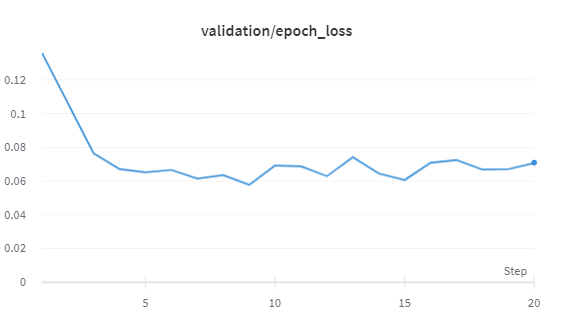

### LeCun Uniform

В этом методе выборки берутся из равномерного распределения в пределах [-предел, предел], где предел равен sqrt(3 / fan_in), где fan_in - количество входных единиц в тензоре веса.<br>
Аргументы:
* начальное значение: целое число в Python. Используется для запуска генератора случайных чисел.

In [ ]:
lecun_uniform, run_dir = training(init_scheme='lecun_uniform')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

lecun_uniform.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

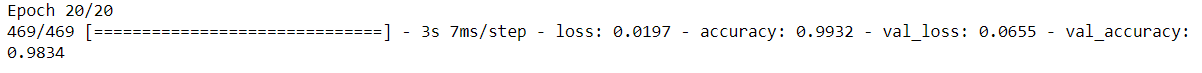

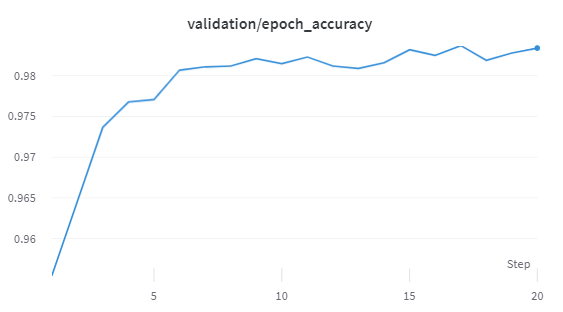

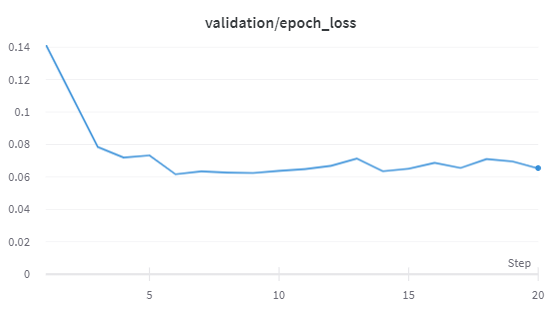

### LeCun Normal

В этом методе выборки извлекаются из усеченного нормального распределения с центром в 0 с помощью stddev = sqrt(1 / fan_in), где fan_in - это количество входных единиц в весовом тензоре.<br>
Аргументы:
* начальное значение: целое число на языке Python. Используется для запуска генератора случайных чисел.

In [ ]:
lecun_normal, run_dir = training(init_scheme='lecun_normal')

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=run_dir, histogram_freq=4, write_images=True)

lecun_normal.fit(X_train, y_train, 
    validation_data=(X_test, y_test), 
    epochs=20, batch_size=128,
    callbacks=[WandbCallback(data_type='image', labels=CLASS_NAMES, 
                             validation_data=(X_test, y_test)),
               tb_callback])

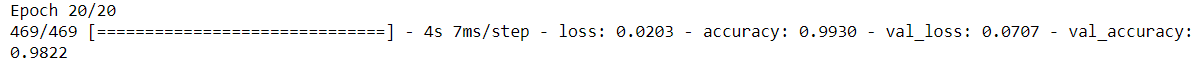

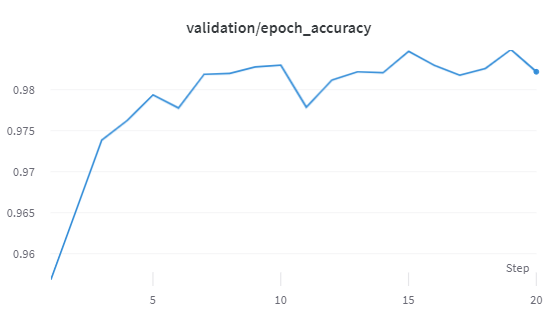

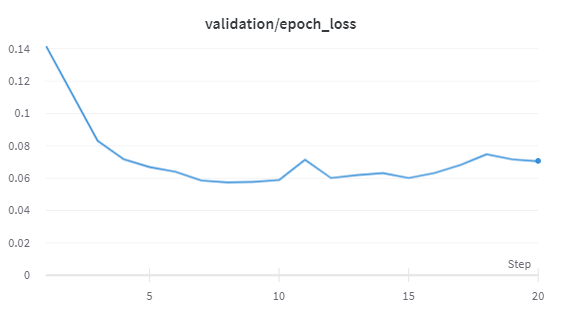

**Conclusion**

Методы инициализации веса, такие как He, Glorot, LeCun и другие, намного лучше, чем некоторые из методов инициализации веса, рассмотренных в начале. Несмотря на то, что инициализаторы random normal и random uniform обладают хорошей точностью, они невоспроизводимы и являются источником проблем с исчезающим и растущим градиентом. Некоторые из новых методов, рассмотренных в конце, устанавливают значения, не превышающие 1, но и не превышающие 1. В дополнение к этому, время, затрачиваемое на сближение, также сокращается. Следовательно, мы можем сделать вывод, что все инициализаторы имеют свое значение, но цель избежать медленной конвергенции остается одной и той же для всех, но лишь немногие способны ее достичь.